<a href="https://colab.research.google.com/github/tejvapraj/Machine_learning_model/blob/main/Final_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import regex as re
import numpy as np
drive.mount('/content/cdrive')

Mounted at /content/cdrive


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Step 2: Load and Preprocess Data
# Load the datasets
train_df = pd.read_excel(r'/content/cdrive/My Drive/Prediction of Placement Status Data/01 Train Data.xlsx')
test_df = pd.read_excel(r'/content/cdrive/My Drive/Prediction of Placement Status Data/02 Test Data.xlsx')

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# Step 1: Drop non-essential columns
train_df = train_df.drop(['First Name', 'Email ID', 'Year of Graduation'], axis=1)
test_df = test_df.drop(['First Name', 'Email ID', 'Year of Graduation'], axis=1)

# Step 2: Convert categorical variables to numerical using Label Encoding
label_encoders = {}
categorical_columns = ['Price Tier', 'Ticket Type', 'Attendee #', 'Group', 'Order Type', 'Currency', 'Attendee Status', 'College Name', 'Designation']

for col in categorical_columns:
    le = LabelEncoder()
    le.fit(train_df[col])
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

# Step 3: One-hot encode specific columns
train_df = pd.get_dummies(train_df, columns=['How did you come to know about this event?', 'Specify in "Others" (how did you come to know about this event)'])
test_df = pd.get_dummies(test_df, columns=['How did you come to know about this event?', 'Specify in "Others" (how did you come to know about this event)'])
train_df = pd.get_dummies(train_df, columns=['Fees Paid'])
test_df = pd.get_dummies(test_df, columns=['Fees Paid'])

# Step 4: Label encode Placement Status
le_placement = LabelEncoder()
train_df['Placement Status'] = le_placement.fit_transform(train_df['Placement Status'])
test_df['Placement Status'] = le_placement.transform(test_df['Placement Status'])

# Assuming 'Placement Status' is the target column
train_df['Placement Status'].fillna(train_df['Placement Status'].mode()[0], inplace=True)
test_df['Placement Status'].fillna(test_df['Placement Status'].mode()[0], inplace=True)


train_df['Placement Status'] = train_df['Placement Status'].map({0: 0, 1: 1, 2: 1})
test_df['Placement Status'] = test_df['Placement Status'].map({0: 0, 1: 1, 2: 1})


# Step 5: Define Features and Target Variable
X_train = train_df.drop('Placement Status', axis=1)
y_train = train_df['Placement Status']

X_test = test_df.drop('Placement Status', axis=1)
y_test = test_df['Placement Status']


In [5]:
# Check for Missing Values
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

# Check Target Variable Labels
unique_labels_train = train_df['Placement Status'].unique()
unique_labels_test = test_df['Placement Status'].unique()

print("Missing Values in Training Data:")
print(missing_values_train)

print("\nMissing Values in Test Data:")
print(missing_values_test)

print("\nUnique Labels in Training Data:")
print(unique_labels_train)

print("\nUnique Labels in Test Data:")
print(unique_labels_test)



Missing Values in Training Data:
Quantity                                                                               0
Price Tier                                                                             0
Ticket Type                                                                            0
Attendee #                                                                             0
Group                                                                                  0
                                                                                      ..
Specify in "Others" (how did you come to know about this event)_Telegram               0
Specify in "Others" (how did you come to know about this event)_Twitter                0
Specify in "Others" (how did you come to know about this event)_You tube               0
Specify in "Others" (how did you come to know about this event)_Yuva Sena/Shiv Sena    0
Fees Paid_0.0                                                                

In [6]:
# Check the size of the training dataset
train_rows, train_columns = train_df.shape

# Check the size of the test dataset
test_rows, test_columns = test_df.shape

print(f"Training Data Size: {train_rows} rows, {train_columns} columns")
print(f"Test Data Size: {test_rows} rows, {test_columns} columns")


Training Data Size: 4894 rows, 128 columns
Test Data Size: 3796 rows, 109 columns


In [7]:
# Step 1: Identify Missing Columns
missing_columns = [col for col in train_df.columns if col not in test_df.columns]

# Step 2: Add Missing Columns to Test Data
test_df = pd.concat([test_df, pd.DataFrame(0, index=test_df.index, columns=missing_columns)], axis=1)

# Step 3: Re-Check Sizes
print(f"Training Data Size: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Test Data Size: {test_df.shape[0]} rows, {test_df.shape[1]} columns")


Training Data Size: 4894 rows, 128 columns
Test Data Size: 3796 rows, 128 columns


In [8]:

unique_labels_train = train_df['Placement Status'].unique()
unique_labels_test = test_df['Placement Status'].unique()

print("Unique Labels in Training Data:")
print(unique_labels_train)

print("\nUnique Labels in Test Data:")
print(unique_labels_test)


Unique Labels in Training Data:
[1 0]

Unique Labels in Test Data:
[1]


In [9]:
import re

# List of columns to remove
columns_to_remove = [
    'How did you come to know about this event?_Youtube | Facebook | Instagram | Whatsapp',
    'How did you come to know about this event?_Facebook | Instagram | Whatsapp | Email',
    'How did you come to know about this event?_Youtube | Facebook | Instagram | LinkedIn | Whatsapp | Email | Cloud Counselage Website',
    'How did you come to know about this event?_Youtube | Facebook | Instagram | LinkedIn | Whatsapp | Email | Telegram | Twitter | Friend/ Classmate',
    'Specify in "Others" (how did you come to know about this event)_From Academy',
    'How did you come to know about this event?_Whatsapp | Telegram',
    'How did you come to know about this event?_Whatsapp | Email | Others',
    'How did you come to know about this event?_Youtube | Facebook | Instagram | LinkedIn | Email | Cloud Counselage Website',
    'How did you come to know about this event?_Instagram | LinkedIn | Cloud Counselage Website',
    'How did you come to know about this event?_Youtube | Instagram | Whatsapp | Email | Cloud Counselage Website',
    'Specify in "Others" (how did you come to know about this event)_Attend',
    'How did you come to know about this event?_LinkedIn | Cloud Counselage Website',
    'How did you come to know about this event?_Youtube | LinkedIn | Cloud Counselage Website',
    'How did you come to know about this event?_Youtube | Facebook | Instagram | Email | Cloud Counselage Website',
    'How did you come to know about this event?_Whatsapp | Email | Cloud Counselage Website | SPOC/ College Professor',
    'How did you come to know about this event?_Youtube | Whatsapp | Email | Cloud Counselage Website',
    'How did you come to know about this event?_Youtube | Instagram | LinkedIn | Whatsapp | Email',
    'Specify in "Others" (how did you come to know about this event)_Telegram',
    'Specify in "Others" (how did you come to know about this event)_Institute'
]

# Escape special characters
columns_to_remove = [re.escape(col) for col in columns_to_remove]

# Create a pattern to match columns
pattern = '|'.join(columns_to_remove)

# Filter columns using pattern
train_df = train_df.filter(regex=f'^(?!{pattern}$)')



In [10]:

# Check the number of features in each dataset
num_features_train = X_train.shape[1]
num_features_test = X_test.shape[1]

# Ensure the number of features match
if num_features_train != num_features_test:
    # If they don't match, you need to handle the mismatch
    print(f"The number of features in the training set ({num_features_train}) "
          f"and test set ({num_features_test}) do not match.")
else:
    # If they match, you can proceed with training and evaluation
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

The number of features in the training set (127) and test set (108) do not match.


In [11]:
print("Number of features in training set:", len(train_df.columns))
print("Number of features in test set:", len(test_df.columns))

Number of features in training set: 102
Number of features in test set: 128


In [12]:

num_missing_columns = num_features_train - num_features_test
X_test = np.hstack((X_test, np.zeros((X_test.shape[0], num_missing_columns))))

In [13]:
# Step 1: Identify the Mismatch
train_columns = set(train_df.columns)
test_columns = set(test_df.columns)
# Find columns present in train but not in test
extra_columns_in_train = train_columns - test_columns

# Find columns present in test but not in train
extra_columns_in_test = test_columns - train_columns

In [14]:
# Print the columns in the DataFrame
print(train_df.columns)

Index(['Quantity', 'Price Tier', 'Ticket Type', 'Attendee #', 'Group',
       'Order Type', 'Currency', 'Total Paid', 'Eventbrite Fees',
       'Eventbrite Payment Processing',
       ...
       'How did you come to know about this event?_Youtube | Whatsapp | Email',
       'How did you come to know about this event?_Youtube | Whatsapp | Friend/ Classmate',
       'Specify in "Others" (how did you come to know about this event)_College',
       'Specify in "Others" (how did you come to know about this event)_Friends',
       'Specify in "Others" (how did you come to know about this event)_Interested',
       'Specify in "Others" (how did you come to know about this event)_Team entity',
       'Specify in "Others" (how did you come to know about this event)_Twitter ',
       'Specify in "Others" (how did you come to know about this event)_You tube',
       'Specify in "Others" (how did you come to know about this event)_Yuva Sena/Shiv Sena',
       'Fees Paid_0.0'],
      dtype='object'

In [15]:
# Identify extra columns in test set
extra_columns = set(test_df.columns) - set(train_df.columns)

# Remove extra columns from test set
test_df = test_df.drop(columns=extra_columns)

# Now both datasets should have the same columns


In [16]:
# Check the size of the training set
train_size = train_df.shape
print("Training Set Size:", train_size)

# Check the size of the test set
test_size = test_df.shape
print("Test Set Size:", test_size)

Training Set Size: (4894, 102)
Test Set Size: (3796, 102)


In [17]:
print("Number of features in training set:", len(train_df.columns))
print("Number of features in test set:", len(test_df.columns))

Number of features in training set: 102
Number of features in test set: 102


In [18]:
# Identify the Mismatch
train_columns = set(train_df.columns)
test_columns = set(test_df.columns)
# Find columns present in train but not in test
extra_columns_in_train = train_columns - test_columns

# Find columns present in test but not in train
extra_columns_in_test = test_columns - train_columns

In [19]:
mismatched_columns_train = set(train_df.columns) - set(test_df.columns)
mismatched_columns_test = set(test_df.columns) - set(train_df.columns)

print("Columns in training set but not in test set:", mismatched_columns_train)
print("Columns in test set but not in training set:", mismatched_columns_test)

Columns in training set but not in test set: set()
Columns in test set but not in training set: set()


In [20]:

actual_labels = test_df['Placement Status'].tolist()
print(actual_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Class distribution after resampling:", Counter(y_resampled))



Class distribution after resampling: Counter({1: 4162, 0: 4162})


In [22]:
from sklearn.model_selection import train_test_split

# Step 6: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [23]:
import pandas as pd

class_distribution = train_df['Placement Status'].value_counts()

print(class_distribution)

class_distribution = test_df['Placement Status'].value_counts()

print(class_distribution)


1    4162
0     732
Name: Placement Status, dtype: int64
1    3796
Name: Placement Status, dtype: int64


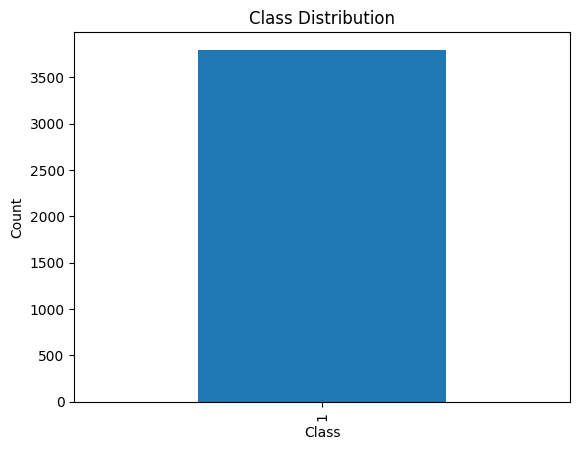

In [24]:
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [25]:
from sklearn.ensemble import RandomForestClassifier

class_weights = {0: 1, 1: 10}  # Adjust the weights as needed
rf_classifier = RandomForestClassifier(class_weight=class_weights, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Evaluate the model
train_accuracy = rf_classifier.score(X_train, y_train)
test_accuracy = rf_classifier.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Training Accuracy: 0.9997445721583652
Test Accuracy: 0.8947906026557712


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the labels
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Evaluate on training set
print("Training Set Metrics:")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

# Evaluate on test set
print("\nTest Set Metrics:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Training Set Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       1.00      1.00      1.00      3337

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915

Confusion Matrix:
[[ 577    1]
 [   0 3337]]

Test Set Metrics:
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       154
           1       0.96      0.92      0.94       825

    accuracy                           0.89       979
   macro avg       0.80      0.85      0.82       979
weighted avg       0.91      0.89      0.90       979

Confusion Matrix:
[[119  35]
 [ 68 757]]


In [27]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:")
print(cv_scores)
print(f"Mean Accuracy: {cv_scores.mean()}")


Cross-Validation Scores:
[0.91060026 0.90166028 0.9054917  0.899106   0.9054917 ]
Mean Accuracy: 0.9044699872286079


In [28]:
# Predict the labels on the test set
y_pred = rf_classifier.predict(X_test)

# Create a DataFrame to compare actual vs predicted labels
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the results
print(results)


      Actual  Predicted
144        0          1
79         1          0
4627       1          1
3832       1          1
4581       1          1
...      ...        ...
964        0          0
168        0          0
3656       1          1
4354       1          1
4481       1          1

[979 rows x 2 columns]


In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter


# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Class distribution after resampling:", Counter(y_resampled))

# Now, use X_resampled and y_resampled for training your model


Class distribution after resampling: Counter({1: 3337, 0: 3337})


In [30]:
import pandas as pd

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})


df['Correct Prediction'] = df['Actual'] == df['Predicted']

# Print the DataFrame to inspect the predictions
print(df)


      Actual  Predicted  Correct Prediction
144        0          1               False
79         1          0               False
4627       1          1                True
3832       1          1                True
4581       1          1                True
...      ...        ...                 ...
964        0          0                True
168        0          0                True
3656       1          1                True
4354       1          1                True
4481       1          1                True

[979 rows x 3 columns]


In [31]:
import pandas as pd


X_test_df = pd.DataFrame(X_test)

# Generate a unique ID for each row
X_test_df['ID'] = range(1, len(X_test_df) + 1)

predictions_df = pd.DataFrame({'ID': X_test_df['ID'], 'Predictions': y_pred})

# Save the predictions to an Excel file
predictions_df.to_excel('/content/cdrive/My Drive/Prediction of Placement Status Data/Placement_predictions.xlsx', index=False)
